In [17]:
#Multivariate Branching process using Agents.jl
using Agents 
using StatsBase
using Plots
using Statistics
using DataFrames
using CSV
using Distributions

In [3]:
# Contradiction between Agents.jl latest doc and julia peroformace tip doc about the most efficient way to define agents

@agent hemato_cell NoSpaceAgent begin
    type::Int8 # A number between 1 and 20 
    age::Int32 #Age of the cell since she left HSC in number of time step
    nbr_division::Int8 #nbr of divisions since the Cell left HSC
    lineage::Array{Int32, 1}
end

#More efficient to only have one type of agents BUT ! a trade-off with memory allocations if I have more parameters 
#Must check run time and memory allocation to see what's better

In [2]:
#Model Initialization:

function initialize_model(t0_cells, Parameters, file) # We expect t0_cells to be an a vector of arrays , each array is a cell with given parameters (type, age, nbr_divisions)
    space = nothing 
    life = ABM(hemato_cell, space; properties = Parameters())
    first_cells = hemato_cell.(1:length(t0_cells), map(x -> x[1], cell0), map(x -> x[2], cell0), map(x -> x[3], cell0), [[0] for i in 1:length(t0_cells)])
    
    
    for cell in  first_cells
        add_agent!(cell, life)
    end

    CSV.write(file, life.deaths)
    return life
end

In [5]:
function cells_creation(model)
    creation_rate = model.creation_rate
    create = sample(0:1, ProbabilityWeights([1 - creation_rate, creation_rate]))
    if create == 1
        add_agent!(hemato_cell(nextid(model), 0, 0, 0, [0]), model)
    end
end

function death_func(age, a = 0.009, c = 0)
    death_rate = a * age + c
	death_prob = [death_rate, 1 - death_rate]
	return sample(0:1, ProbabilityWeights(death_prob))
end

function division_func(age, a = -0.009, c = 0.3)
    division_rate = a * age + c
	division_prob = [1 - division_rate, division_rate]
	return sample(0:1, ProbabilityWeights(division_prob))
end

function division!(cell::hemato_cell, model)
    if division_func(cell.age) == 1
        divisions = cell.nbr_division + 1
        add_agent!(hemato_cell(nextid(model), cell.type, cell.age, cell.nbr_division, cell.lineage), model)
        add_agent!(hemato_cell(nextid(model), cell.type, cell.age, cell.nbr_division, cell.lineage), model)
        remove_agent!(cell, model)
    end
end

function transition_func(cell::hemato_cell, matrix::Matrix{Float16}, nbr_state::Int8)
    type = sample(1:nbr_state, matrix[ : ,cell.type])
    return type
end

function transition!(cell::hemato_cell, model)
    cell.type = transition_func(cell)
    push!(cell.lineage, [cell.type, cell.id])
end

function life_step!(cell::hemato_cell, model)
    #here df will be a dataframe rinitialized at each model step, it stores all the data of the cells which division_rate
    #at each model step we write the deaths in a external file using Arrow.jl 
    #But actually maybe it's more efficient to create an arrow object write into it for each cell and then fuse it withe the big arrow object ?
    if death_func(cell.age) == 1 #in case of survival
        division_rate = division_func(cell.age)
        cell.age += 1
        division!(cell, model, division_rate)
    else
        remove_agent!(cell, model)     
    end
    
end

function model_step!(model, file)
    CSV.write(file, model.deaths, append = true)
    empty!(model.deaths)
end

model_step! (generic function with 1 method)

In [2]:
#Testing:
#Parameters definition and initialization:
Base.@kwdef mutable struct Parameters
    creation_rate::Float64 = 1.0
    deaths::DataFrame = DataFrame(id = [], age = [], nbr_division = [], lineage = [])
    nbr_state::Int64 = 3 # for rand()  to generate a matrix and not a vector of vector nbr_state must be a Int64 and not a Int8
end
cell0 = [[1, 0, 0],[2, 0, 0]]

file = "C:\\Users\\ambre\\Documents\\ENS\\stage_M1\\code_1\\test_file"
df = DataFrame(cell0, :auto)

life = initialize_model(cell0, Parameters, file)



UndefVarError: UndefVarError: `initialize_model` not defined

We want for each state to determine a distribution of division rate based on informations found online about cell-type division. 

On the website BioNumbers, we found for LT-HSC: 77% have divided after 17.8 days and 99% have divided after 57 days.
We 

In [2]:
function shifted_exponential_param(T,X) # X an T are tuples of 2 points T= (t1, t2) and X = (x1, x2)
    L = ( T[2] * log(1 - X[1])/(log(1 - X[2])) + T[1] ) * 1/(1 - log(1 - X[1]))
    lambda = log(1 - X[2])/(L - T[2])
    return (lambda, L)
end

 function shifted_exponential_sampling(lambda, L)
     alea = rand(Float16)
     return (alea, -log(1 - alea)/lambda + L)
 end

shifted_exponential_sampling (generic function with 1 method)

We test wether or not this sampling method appear to give something which make sense.

In [10]:
param = shifted_exponential_param((17.8, 57), (0.77, 0.99))
x = []
y = []
for _ in 1:1000
    results = shifted_exponential_sampling(param[1], param[2])
    push!(x, results[1])
    push!(y, results[2])
end


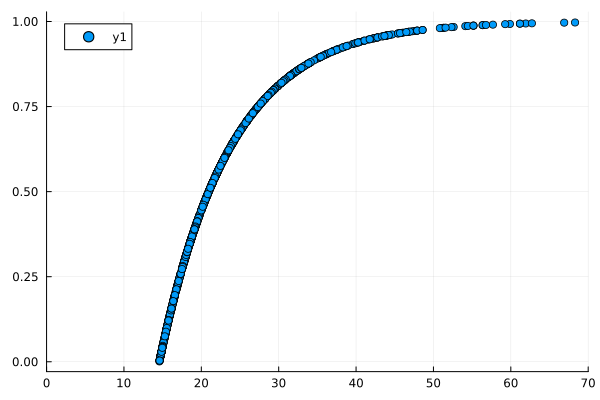

In [12]:
scatter(y,x, xlimits = (0,70))

we modify the initialize model so that a division time is drawn from the distribution.

In [18]:
#Agent definition

@agent hemato_cell2 NoSpaceAgent begin
    type::Int # A number between 1 and 20 
    age::Int #Age of the cell since she left HSC in number of time step
    nbr_division::Int #nbr of divisions since the Cell left HSC
    lineage::Array{Int, 1} # an array of int of the form [..., id, step, type, ...]
    divsion_time::Int
end

In [19]:
#Definition of the model parameters 
Base.@kwdef mutable struct Parameters
    s::Int = 0 #the time step of the model
    n_steps::Int = 10 #total number of steps
    creation_rate::Float64 = 1.0 #rate at which cell are created (temporary as long as niche not implemented)
    deaths::DataFrame = DataFrame(id = [], age = [], nbr_division = [], lineage = [])
    nbr_state::Int64 = 3 # for rand()  to generate a matrix and not a vector of vector nbr_state must be a Int64 and not a Int8
    file::String = "C:\\Users\\ambre\\Documents\\ENS\\stage_M1\\code_1\\test_file" #file to register the deaths
    matrix::Matrix = rand(Dirichlet(nbr_state, 2), nbr_state) #Initialisation of the transition matrix, here at random
    param::Tuple{Float64, Float64} = shifted_exponential_param((17.8, 57), (0.77, 0.99)) #parameter of the shifted exponential used to sample division time
    
end

Parameters

In [192]:
#Functions of the model

function initialize_model(t0_cells, Parameters, n_steps) # We expect t0_cells to be an a vector of arrays , each array is a cell with given parameters (type, age, nbr_divisions)
    space = nothing 
    life = ABM(hemato_cell2, space; properties = Parameters())
    first_cells = hemato_cell2.(1:length(t0_cells), map(x -> x[1], cell0), map(x -> x[2], cell0), map(x -> x[3], cell0), [[0] for i in 1:length(t0_cells)], [round(shifted_exponential_sampling(param[1], param[2])[2]) for _ in 1:length(t0_cells)])
    life.n_steps = n_steps
    
    for cell in  first_cells
        add_agent!(cell, life)
    end

    CSV.write(life.file, life.deaths)
    return life
end

function cells_creation(model)
    creation_rate = model.creation_rate
    create = sample(0:1, ProbabilityWeights([1 - creation_rate, creation_rate]))
    if create == 1
        add_agent!(hemato_cell(nextid(model), 0, 0, 0, [0], round(shifted_exponential_sampling(model.param[1], model.param[2])[2])))
    end
end

function death_func(age; a = 0.0009, c = 0)
    death_rate = a * age + c
	death_prob = [death_rate, 1 - death_rate]
	return sample(0:1, ProbabilityWeights(death_prob))
end

function division!(cell::hemato_cell2, model)
    divisions = cell.nbr_division + 1
    lineage = vcat(cell.lineage, [cell.id, model.s, cell.type])
    add_agent!(hemato_cell2(nextid(model), cell.type, 0, divisions, lineage, round(shifted_exponential_sampling(model.param[1], model.param[2])[2])), model)
    add_agent!(hemato_cell2(nextid(model), cell.type, 0, divisions, copy(lineage), round(shifted_exponential_sampling(model.param[1], model.param[2])[2])), model)
    remove_agent!(cell, model)
end

function transition_func(cell::hemato_cell2, matrix::Matrix{Float64}, nbr_state::Int)
    type = sample(1:nbr_state, ProbabilityWeights(matrix[ : ,cell.type]))
    return type
end

function transition!(cell::hemato_cell2, model, matrix)
    type = transition_func(cell, matrix, model.nbr_state)
    if type != cell.type
        push!(cell.lineage, cell.id, model.s, type)
        cell.type = type
    end
end

function life_step!(cell::hemato_cell2, model)
    if death_func(cell.age, a = 0.0009, c = 0) == 1 #in case of survival
        cell.age += 1
        transition!(cell, model, model.matrix)
        if cell.age == cell.divsion_time
            division!(cell, model)
        end
    else
        push!(model.deaths, [cell.id, cell.age, cell.nbr_division, cell.lineage])  
        remove_agent!(cell, model)
    end
    
end

function model_step!(model)
    CSV.write(model.file, model.deaths, append = true)
    empty!(model.deaths)
    model.matrix = rand(Dirichlet(model.nbr_state, 2), model.nbr_state)
    model.s += 1
end

model_step! (generic function with 1 method)

We want to record cells only in the end because we record deaths and cells are given the next id when they appear. Therefore, we can represent the life of the n cells (n being the last id) by the data of dead and the data of cells alive at the last time step. We don't need the step by step info as we record step of transition and division.

We are going to use a custom function `run!` to record such data.

What we want is to obtain data to plot a tree using the NetworkLayout pakage (we will need a adjacent list to feed it to the Buchheim tree function in this function, for more details [see this page](https://juliagraphs.org/NetworkLayout.jl/stable/#Basic-Usage-and-Algorithms)). For more details about adjacent lists and matrix [see this page](https://www.geeksforgeeks.org/comparison-between-adjacency-list-and-adjacency-matrix-representation-of-graph/)

In [137]:
function custom_run!(model, agent_step!, model_step!, properties)
    #properties is a Vector of Symbol
    step!(model, agent_step!, model_step!, life.n_steps)
    return custom_collect_agent_data!(model, adata)
end

custom_run! (generic function with 2 methods)

In [138]:
function custom_collect_agent_data!(model, properties::Vector)
    alla = sort!(collect(allagents(model)), by = a -> a.id)
    dd = DataFrame()
    dd[!, :id] = map(a -> a.id, alla)
    for fn in properties
        # Extract data for each property using getfield
        dd[!, fn] = getfield.(alla, fn)
    end
    return dd
end



custom_collect_agent_data! (generic function with 4 methods)

In [193]:
cell0 = [[1, 0, 0], [2, 0, 0]]
n_steps = 20
life = initialize_model(cell0, Parameters, n_steps)

adata = [:type, :lineage]

data = custom_run!(life, life_step!, model_step!, adata)

life

StandardABM with 3 agents of type hemato_cell2
 space: nothing (no spatial structure)
 scheduler: fastest
 properties: s, n_steps, creation_rate, deaths, nbr_state, file, matrix, param

In [194]:
print(data.lineage[2])

[0, 2, 1, 1, 2, 2, 3, 2, 3, 2, 2, 4, 1, 2, 5, 3, 2, 6, 1, 2, 9, 3, 2, 10, 2, 2, 11, 3, 2, 13, 1, 2, 14, 3, 2, 15, 1, 2, 16, 2, 2, 17, 3, 2, 17, 3, 3, 17, 1, 3, 18, 2, 3, 19, 3]

In [195]:
print(data.lineage[3])

[0, 2, 1, 1, 2, 2, 3, 2, 3, 2, 2, 4, 1, 2, 5, 3, 2, 6, 1, 2, 9, 3, 2, 10, 2, 2, 11, 3, 2, 13, 1, 2, 14, 3, 2, 15, 1, 2, 16, 2, 2, 17, 3, 2, 17, 3, 4, 18, 2]

Minute reflexion:
dans un fichier on enregistre toutes les datas d'une cellule quand elle meurt => on a acces a tout le lignage, on garde tout au début mais ensuite pour des questions d'efficacité que le lignage

A chaque division on enregistre l'ID ? ou a chaque transition ? est ce qu'on a besoin de savoir quelles cellules sont soeur au sein de cellules de meme type ? je pense pas
Donc lineage is the array of cells which underwent transition in the form  [state, ID, state, ID,...]

On va enregistrer a la fin du run tous les lignages etat et division 

In [44]:
using NetworkLayout

Row,id,age,nbr_division,lineage
,Any,Any,Any,Any


Lymphocyte Differentiation Toy model: